In [1]:
%load_ext autoreload
%autoreload 2

import timm
from omegaconf import OmegaConf
from ml_utilities.data.datasetgenerator import DatasetGenerator
from tflearning.sample_difficulty import prediction_depth as pdepth
import torch.utils.data as data
import numpy as np


In [2]:
resnet = timm.create_model('resnet18', pretrained=True)

In [3]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [4]:
# create dataset cf10 train split
data_cfg = """
data:
  dataset: cifar10
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data
  dataset_split:
    train_val_split: 0.9
    restrict_n_samples_train_task: 1000
"""
data_cfg = OmegaConf.create(data_cfg)
cf10_ds_gen = DatasetGenerator(**data_cfg.data)
cf10_ds_gen.generate_dataset()
cf10_train = cf10_ds_gen.train_split
cf10_val = cf10_ds_gen.val_split
cf10_trainloader = data.DataLoader(cf10_train, batch_size=128, shuffle=False)
cf10_valloader = data.DataLoader(cf10_val, batch_size=128, shuffle=False)

Files already downloaded and verified


In [5]:
layer_names = pdepth.find_layer_names(resnet, 'act2')
layer_names.append('act1') # add the last layer (activation) of the first block

In [6]:
layer_names

['layer1.0.act2',
 'layer1.1.act2',
 'layer2.0.act2',
 'layer2.1.act2',
 'layer3.0.act2',
 'layer3.1.act2',
 'layer4.0.act2',
 'layer4.1.act2',
 'act1']

In [7]:
pred_depth = pdepth.PredictionDepth(resnet,
                                    layer_names,
                                    train_dataloader=cf10_trainloader,
                                    test_dataloader=cf10_valloader, 
                                    prediction_depth_mode='ground_truth_label',
                                    append_softmax_output=False)

Computing kNN predictions: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


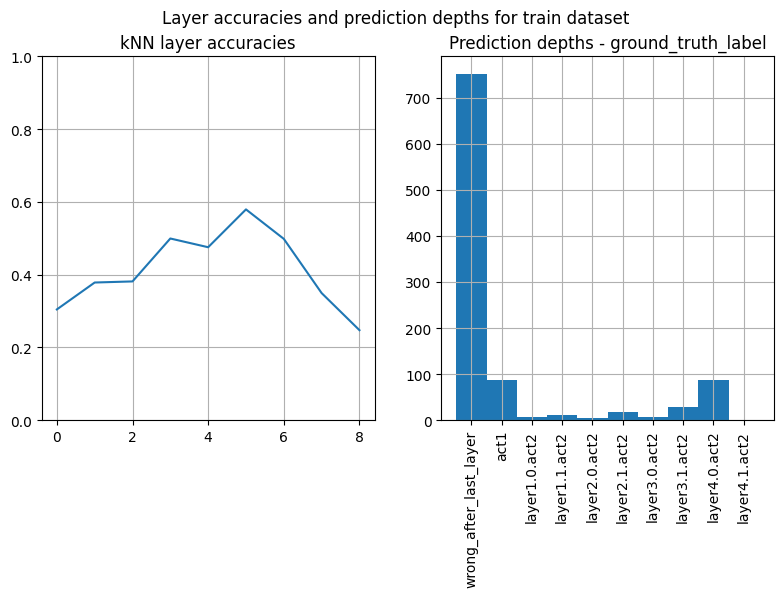

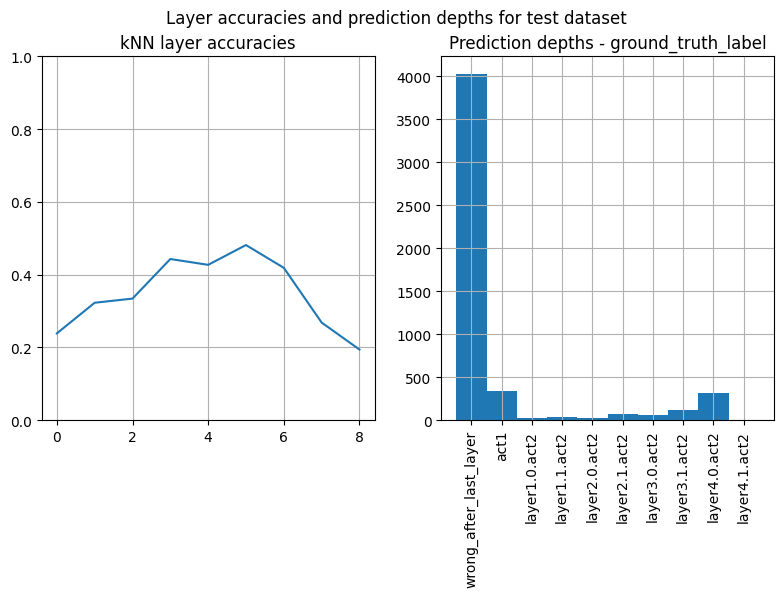

In [8]:
plots = pred_depth.make_plots()

In [9]:
layer_preds = pred_depth.pred_depth_results['train']['layer_preds']

In [10]:
layer_preds[:5, :]

array([[6, 6, 6, 6, 6, 6, 6, 6, 6],
       [3, 6, 8, 8, 1, 8, 8, 6, 6],
       [2, 6, 6, 6, 6, 7, 7, 7, 7],
       [5, 6, 6, 6, 4, 3, 7, 7, 3],
       [2, 4, 6, 6, 6, 5, 7, 6, 6]])

In [11]:
labels = np.array([6,5,7,3,6])

In [12]:
pdepth.pred_depth_fn(layer_preds[:5, :], labels)

array([ 0., -1.,  4.,  7.,  6.])

In [13]:
bins = np.arange(-1, len(pred_depth.layer_names_ordered)+1, 1) - 0.5

In [14]:
bins

array([-1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5])